<a href="https://colab.research.google.com/github/lnsayer/personal_repo/blob/main/drug%20discovery%20with%20BACE%20dataset/graph_classification_bace_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!pip install rdkit
!pip install torch_geometric
!pip install deepchem
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.0 MB/s eta 0:00:00


In [2]:
# Import necessary modules
import requests
from pathlib import Path
import os.path as osp

from rdkit import Chem
from rdkit.Chem import Draw

import torch
import torch_geometric
from torch_geometric.data import InMemoryDataset, Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear, ReLU, Dropout, Softmax
import torch.nn as nn
import torch.nn.functional as F


import deepchem as dc
from deepchem.feat.graph_data import GraphData

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx

import random

from tqdm.auto import tqdm

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [3]:
# Specify Paths to where data is stored (will have raw and processed files)
data_path = Path("data/")
bace_path = data_path / "raw"

print(type(bace_path))
print(bace_path)

<class 'pathlib.PosixPath'>
data/raw


In [4]:
# Check if Bace csv file has been downloaded, if not, download it
if bace_path.is_dir():
  print(f"{bace_path} is already a directory")
else:
  print(f"{bace_path} is not a directory, creating one")
  bace_path.mkdir(parents=True, exist_ok=True)

  with open(bace_path / "bace.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/lnsayer/personal_repo/main/drug%20discovery%20with%20BACE%20dataset/data/bace.csv")
    print("Downloading data")
    f.write(request.content)

data/raw is not a directory, creating one


In [5]:
# Turn CSV file into a dataframe and resave it without unnecessary columns
bace_df = pd.read_csv(bace_path/ "bace.csv")
bace_df = bace_df[["mol", "CID", "Class", "Model", "pIC50"]]
bace_df.to_csv(bace_path/"bace.csv")

bace_df

,mol,CID,Class,Model,pIC50
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970
...,...,...,...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298


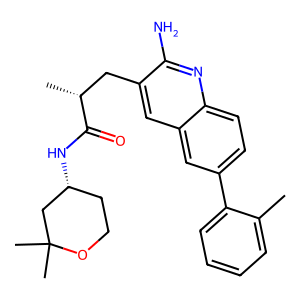

In [6]:
# Visualise one of the molecules from its SMILE input
inhibitor = bace_df["mol"][0]

m = Chem.MolFromSmiles(inhibitor)

img = Draw.MolToImage(m)

display(img)

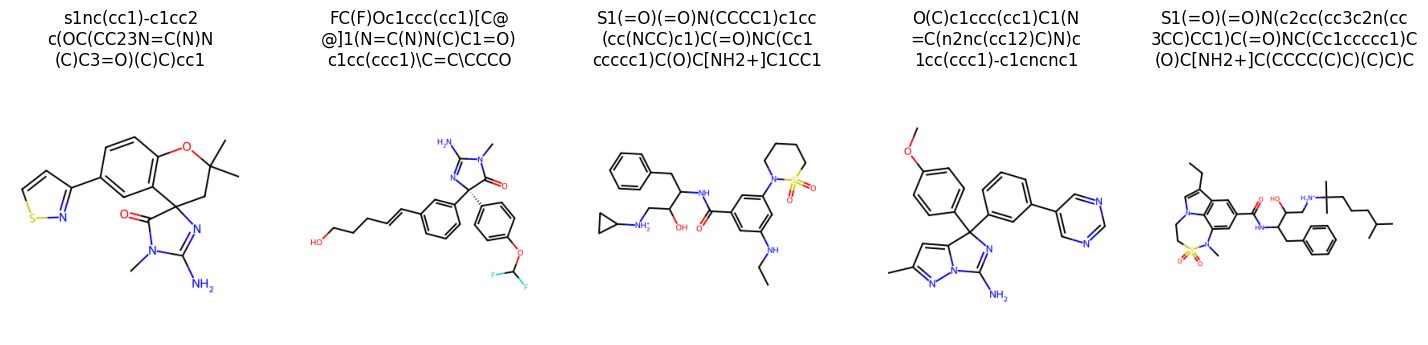

In [7]:
# Display five random molecules with their SMILES molecules

# Create axes and sample SMILES molecules
fig, ax = plt.subplots(ncols=5, nrows=1, figsize = (18,6))
mols = bace_df.sample(n=5, random_state=42)["mol"]

for i in range(len(mols)):

  # Convert each molecule to an image
  mol = mols.iloc[i]
  m = Chem.MolFromSmiles(mol)
  img = Draw.MolToImage(m)

  # Plot each molecule
  ax[i].imshow(img)
  ax[i].axis(False);

  # Divide the SMILE input into three parts
  first_part = mol[:int(len(mol)/3)]
  second_part = mol[int(len(mol)//3):int(2*len(mol)//3)]
  third_part = mol[int(2*len(mol)//3):]

  assert len(mol) == len(first_part)+len(second_part)+len(third_part)

  first_title = first_part + "\n"
  second_title = second_part + "\n"
  third_title = third_part + "\n"

  # Title each plot with its respective SMILE input
  ax[i].set_title(first_title+second_title+third_title)

In [8]:
# Test converting a molecule into a graph using MolGraphConvFeaturizer and to_pyg_graph

# Select first molecule
mol = bace_df["mol"][1]

# Instantiate MolGraphConvFeaturizer class
featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

# Convert SMILES molecule into a DeepChem graph
out = featurizer.featurize(datapoints=mol)

# Convert into torch geometric graph
pyg_out = GraphData.to_pyg_graph(out[0])
pyg_out.y = torch.tensor([bace_df["Class"][0]])

print(pyg_out)

Data(x=[47, 30], edge_index=[2, 100], edge_attr=[100, 11], y=[1])


In [9]:
# Custom torch geometric Dataset class to store the samples and their corresponding labels

class MoleculeDataset(Dataset):
  def __init__(self, root, csv_file, transform=None, pre_transform=None, pre_filter=None):
    """
    root = Where the dataset should be stored. This folder is split
    into raw_dir (downloaded dataset) and processed_dir(processed data).
    """
    self.csv_file = csv_file
    super().__init__(root, transform, pre_transform, pre_filter)

  @property
  def raw_file_names(self):
    """
    If this file exists in raw_dir, the download is not triggered/
    (the download function is not implemented here)
    """
    return self.csv_file

  @property
  def processed_file_names(self):
    """
    If these files are found in raw_dir, processing is skipped
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()

    return [f'data_{i}.pt' for i in list(self.data.index)]

  def download(self):
    """
    No need to download the csv file as it is already downloaded
    """
    pass

  def process(self):
    """
    I used Deepchem's MolGraphConvFeaturizer to create a graph and then convert that to a torch graph with to_pyg_graph.
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()
    featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

    for idx, row in self.data.iterrows():
      # Featurize molecule and convert to torch graph
      smiles = row['mol']
      label = row['Class']
      pic50 = row['pIC50']

      out = featurizer.featurize(smiles)
      pyg_out = GraphData.to_pyg_graph(out[0])
      pyg_out.Class = torch.tensor([label])
      pyg_out.smiles = smiles
      pyg_out.pic50 = pic50

      # data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index, edge_attr=pyg_out.edge_attr,
      #            y=torch.tensor([label]), dtype = torch.float)

      torch.save(pyg_out, osp.join(self.processed_dir, f'data_{idx}.pt'))

  def len(self):
    """
    Returns number of samples in the dataset
    """
    return len(self.processed_file_names)

  def get(self, idx):
    """
    Loads a single graph
    """
    data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [10]:
# Instantiate the dataset from the BACE CSV file

original_dataset = MoleculeDataset(root = "data/", csv_file = "bace.csv").shuffle()
dataset = original_dataset

train_indices = int(0.8*len(dataset))

train_dataset = dataset[:train_indices]
test_dataset = dataset[train_indices:]


print(f"Total dataset samples: {len(dataset)}\nTrain dataset samples: {len(train_dataset)}\nTest dataset samples: {len(test_dataset)}")

Processing...


Total dataset samples: 1513
Train dataset samples: 1210
Test dataset samples: 303


Done!


In [11]:
# Calculate average nodes and edges in the graphs
avg_nodes = 0
avg_edges = 0
for i in range(len(original_dataset)):
  avg_nodes+=original_dataset[i].x.shape[0]/len(original_dataset)
  avg_edges+=original_dataset[i].edge_index.shape[1]/len(original_dataset)
print(f"avg nodes: {avg_nodes:.4f}, avg_edges: {avg_edges:.4f}")



avg nodes: 34.0892, avg_edges: 73.7184


In [12]:
# Create a dataloader from the dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Number of batches: {len(train_dataloader)}")
print(f"Number of samples: {len(train_dataset)}")

Number of batches: 38
Number of samples: 1210


In [13]:
# Load a single graph

print(f"Number of nodes in graph is: {train_dataset[0].x.shape[0]}")
print(f"Number of features for each node is {train_dataset[0].num_features}")
print(f"Number of edges is {train_dataset[0].edge_index.shape[1]}")
print(f"Data object is {train_dataset[0]}\n")

Number of nodes in graph is: 41
Number of features for each node is 30
Number of edges is 88
Data object is Data(x=[41, 30], edge_index=[2, 88], edge_attr=[88, 11], Class=[1], smiles='FC(F)(F)c1cc(ccc1)C[NH2+]C[C@@H](O)[C@@H](NC(=O)c1cc(N2CCCC2=O)cc(NCC)c1)Cc1ccccc1', pic50=7.3979402)



In [14]:
# Node features for one the graphs. This class is a featurizer of general graph convolution networks for molecules.
# The default node(atom) and edge(bond) representations are based on WeaveNet paper.

# train_dataset[0].x

In [15]:
# See the format for a batch
print(next(iter(train_dataloader)))

DataBatch(x=[1122, 30], edge_index=[2, 2426], edge_attr=[2426, 11], Class=[32], smiles=[32], pic50=[32], batch=[1122], ptr=[33])


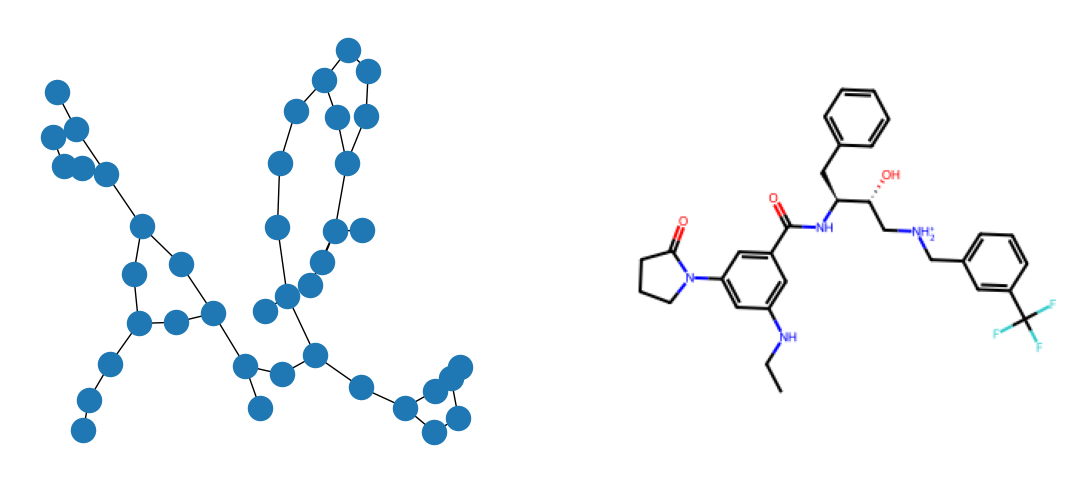

In [16]:
np.random.seed(44)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (14,6))

g = torch_geometric.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw(g, ax = ax[0])

mol = dataset[0].smiles
m = Chem.MolFromSmiles(mol)
img = Draw.MolToImage(m)

ax[1].imshow(img)
ax[1].axis(False);

In [17]:
for batch in enumerate(train_dataloader):
  print(batch)

(0, DataBatch(x=[1035, 30], edge_index=[2, 2244], edge_attr=[2244, 11], Class=[32], smiles=[32], pic50=[32], batch=[1035], ptr=[33]))
(1, DataBatch(x=[1106, 30], edge_index=[2, 2364], edge_attr=[2364, 11], Class=[32], smiles=[32], pic50=[32], batch=[1106], ptr=[33]))
(2, DataBatch(x=[1098, 30], edge_index=[2, 2376], edge_attr=[2376, 11], Class=[32], smiles=[32], pic50=[32], batch=[1098], ptr=[33]))
(3, DataBatch(x=[1100, 30], edge_index=[2, 2388], edge_attr=[2388, 11], Class=[32], smiles=[32], pic50=[32], batch=[1100], ptr=[33]))
(4, DataBatch(x=[1011, 30], edge_index=[2, 2196], edge_attr=[2196, 11], Class=[32], smiles=[32], pic50=[32], batch=[1011], ptr=[33]))
(5, DataBatch(x=[1038, 30], edge_index=[2, 2250], edge_attr=[2250, 11], Class=[32], smiles=[32], pic50=[32], batch=[1038], ptr=[33]))
(6, DataBatch(x=[1067, 30], edge_index=[2, 2314], edge_attr=[2314, 11], Class=[32], smiles=[32], pic50=[32], batch=[1067], ptr=[33]))
(7, DataBatch(x=[1163, 30], edge_index=[2, 2510], edge_attr=[2

In [18]:
# Create tensor of the average of the node features for all 1210 training samples
a = torch.tensor(())
for idx, data in enumerate(train_dataloader):
  x = global_mean_pool(data.x, data.batch)
  a = torch.cat((a, x), 0)


In [19]:
print(a.shape)
df = pd.DataFrame(a.numpy())
# display(df)
corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

torch.Size([1210, 30])


In [20]:
class GCNClassifier(torch.nn.Module):
  """
  Standard GCN graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GCNConv(in_channels, hidden_channels)

    self.conv2 = GCNConv(hidden_channels, hidden_channels)

    self.conv3 = GCNConv(hidden_channels, hidden_channels)

    # Linear layer used in classification
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = global_mean_pool(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GCNClassifier(7, 64, 2)

GCNClassifier(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Send model to device
  model.to(device)
  model.train()

  train_loss, train_acc = 0, 0

  # Loop over the batches
  for idx, batch in enumerate(dataloader):
    batch = batch.to(device)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Forward pass
    out = model(batch)

    # Calculate the loss
    loss = loss_fn(out, batch.Class)
    train_loss += loss.item()

    # Calculate the label predictions
    label_preds = torch.argmax(out, dim=1)
    # Calculate accuracy
    train_acc += (label_preds == batch.Class).sum()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader.dataset)
  train_acc = train_acc/len(dataloader.dataset)

  return train_loss, train_acc

In [22]:
def test_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in eval mode
  model.eval()

  test_loss, test_acc = 0, 0

  # Turn on torch inference manager
  with torch.inference_mode():
    # Loop through data batches
    for idx, batch in enumerate(dataloader):
      batch = batch.to(device)

      # Forward pass
      out = model(batch)

      # Calculate the loss
      loss = loss_fn(out, batch.Class)
      test_loss += loss.item()

      # Calculate the label predictions
      label_preds = torch.argmax(out, dim=1)
      # Calculate accuracy
      test_acc += (label_preds == batch.Class).sum()/len(label_preds)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)

    return test_loss, test_acc

In [23]:
# Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5):

  # 2. Create empty results dictionary
  results = {"epoch": [],
             "train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }
  # 3. Loop through training and testing steps for a number of epochs

  for i in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer)
    test_loss, test_acc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    optimizer)


    # 4. Print out what's happening

    print(f"Epoch: {i}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

    # 5. Update results dictionary

    results["epoch"].append(i)
    results["train_loss"].append(round(train_loss, 4))
    results["train_acc"].append(round(train_acc.item(), 4))
    results["test_loss"].append(round(test_loss, 4))
    results["test_acc"].append(round(test_acc.item(), 4))


   # 6. Return the filled results at the end of the epochs

  return results

In [24]:
torch.manual_seed(42)

# Number of features of the graphs
print(next(iter(train_dataloader)))
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
nb_epochs = 300

# Instantiating GCN Classifier
model = GCNClassifier(num_features, num_hidden_channels, num_out_channels)

adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sgd_optimizer = torch.optim.SGD(model.parameters())

criterion = torch.nn.CrossEntropyLoss()

results = train(model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs
      )

DataBatch(x=[1107, 30], edge_index=[2, 2412], edge_attr=[2412, 11], Class=[32], smiles=[32], pic50=[32], batch=[1107], ptr=[33])


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0217, Train acc: 0.5099, Test loss: 0.6764, Test acc: 0.5842
Epoch: 1, Train loss: 0.0216, Train acc: 0.5355, Test loss: 0.6845, Test acc: 0.5904
Epoch: 2, Train loss: 0.0214, Train acc: 0.5554, Test loss: 0.6717, Test acc: 0.5998
Epoch: 3, Train loss: 0.0212, Train acc: 0.5694, Test loss: 0.6478, Test acc: 0.6675
Epoch: 4, Train loss: 0.0209, Train acc: 0.5901, Test loss: 0.6295, Test acc: 0.6444
Epoch: 5, Train loss: 0.0206, Train acc: 0.6008, Test loss: 0.6187, Test acc: 0.6483
Epoch: 6, Train loss: 0.0202, Train acc: 0.6446, Test loss: 0.6373, Test acc: 0.6385
Epoch: 7, Train loss: 0.0201, Train acc: 0.6215, Test loss: 0.6002, Test acc: 0.6765
Epoch: 8, Train loss: 0.0202, Train acc: 0.6314, Test loss: 0.6164, Test acc: 0.6783
Epoch: 9, Train loss: 0.0198, Train acc: 0.6504, Test loss: 0.6202, Test acc: 0.6596
Epoch: 10, Train loss: 0.0196, Train acc: 0.6595, Test loss: 0.6272, Test acc: 0.6671
Epoch: 11, Train loss: 0.0195, Train acc: 0.6678, Test loss: 0.5

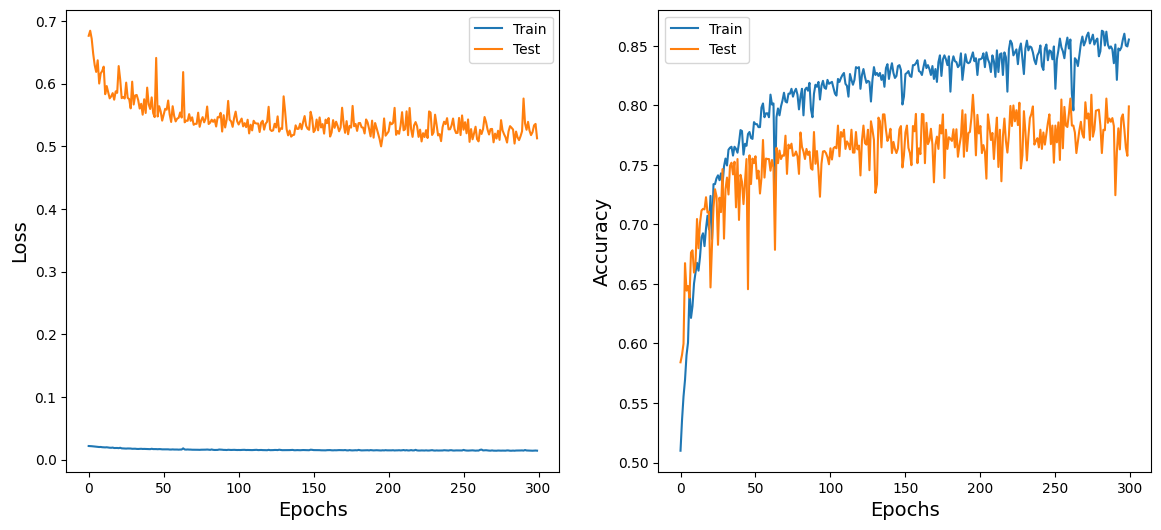

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (14,6))

ax[0].plot(np.arange(0, nb_epochs), results["train_loss"], label="Train");
ax[0].plot(np.arange(0, nb_epochs), results["test_loss"],  label="Test");

ax[1].plot(np.arange(0, nb_epochs), results["train_acc"], label="Train");
ax[1].plot(np.arange(0, nb_epochs), results["test_acc"],  label="Test");

ax[0].set_xlabel("Epochs", size=14)
ax[0].set_ylabel("Loss", size=14)

ax[1].set_xlabel("Epochs", size=14)
ax[1].set_ylabel("Accuracy", size=14)

ax[0].legend();
ax[1].legend();

In [26]:
# Try using our training model on an easier dataset
torch.manual_seed(42)

from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

train_indices = int(0.8*len(dataset))

train_dataset = dataset[:train_indices]
test_dataset = dataset[train_indices:]

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Processing...
Done!


In [27]:
torch.manual_seed(42)
print(len(train_dataset), len(test_dataset))

for step, data in enumerate(train_dataloader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

150 38
Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2574], x=[1165, 7], edge_attr=[2574, 4], y=[64], batch=[1165], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2488], x=[1127, 7], edge_attr=[2488, 4], y=[64], batch=[1127], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 868], x=[392, 7], edge_attr=[868, 4], y=[22], batch=[392], ptr=[23])



In [28]:
next(iter(train_dataloader))

DataBatch(edge_index=[2, 2632], x=[1187, 7], edge_attr=[2632, 4], y=[64], batch=[1187], ptr=[65])

In [29]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Send model to device
  model.to(device)
  model.train()

  train_loss, train_acc = 0, 0

  # Loop over the batches
  for idx, data in enumerate(dataloader):
    data = data.to(device)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Forward pass
    out = model(data)

    # Calculate the loss
    loss = loss_fn(out, data.y)
    train_loss += loss.item()

    # Calculate the label predictions
    label_preds = torch.argmax(out, dim=1)
    # Calculate accuracy
    train_acc += (label_preds == data.y).sum()/len(label_preds)

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)

  return train_loss, train_acc

In [30]:
torch.manual_seed(42)
def test_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in eval mode
  model.eval()

  test_loss, test_acc = 0, 0

  # Turn on torch inference manager
  with torch.inference_mode():
    # Loop through data batches
    for idx, data in enumerate(dataloader):
      data = data.to(device)

      # Forward pass
      out = model(data)

      # Calculate the loss
      loss = loss_fn(out, data.y)
      test_loss += loss.item()

      # Calculate the label predictions
      label_preds = torch.argmax(out, dim=1)
      # Calculate accuracy
      test_acc += (label_preds == data.y).sum()/len(label_preds)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)

    return test_loss, test_acc

In [31]:
torch.manual_seed(42)

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
nb_epochs = 150

# Instantiating GCN Classifier
model = GCNClassifier(num_features, num_hidden_channels, num_out_channels)

adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sgd_optimizer = torch.optim.SGD(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

results = train(model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      criterion,
      epochs = nb_epochs
      )

<IPython.core.display.Javascript object>

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.7011, Train acc: 0.3551, Test loss: 0.6978, Test acc: 0.2632
Epoch: 1, Train loss: 0.6924, Train acc: 0.5161, Test loss: 0.6790, Test acc: 0.6842
Epoch: 2, Train loss: 0.6811, Train acc: 0.6648, Test loss: 0.6708, Test acc: 0.6842
Epoch: 3, Train loss: 0.6697, Train acc: 0.6747, Test loss: 0.6598, Test acc: 0.6842
Epoch: 4, Train loss: 0.6529, Train acc: 0.7045, Test loss: 0.6523, Test acc: 0.6842
Epoch: 5, Train loss: 0.6595, Train acc: 0.6548, Test loss: 0.6413, Test acc: 0.6842
Epoch: 6, Train loss: 0.6538, Train acc: 0.6449, Test loss: 0.6296, Test acc: 0.6842
Epoch: 7, Train loss: 0.6441, Train acc: 0.6548, Test loss: 0.6347, Test acc: 0.6842
Epoch: 8, Train loss: 0.6491, Train acc: 0.6349, Test loss: 0.6231, Test acc: 0.6842
Epoch: 9, Train loss: 0.6249, Train acc: 0.6847, Test loss: 0.6187, Test acc: 0.6842
Epoch: 10, Train loss: 0.6029, Train acc: 0.7045, Test loss: 0.6134, Test acc: 0.6842
Epoch: 11, Train loss: 0.6327, Train acc: 0.6548, Test loss: 0.6